In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../')
import fooof
from fooof.sim.gen import gen_aperiodic      # for looking at aperiodic details
from fooof.plts.spectra import plot_spectrum # for looking at aperiodic details
#from fooof.plts.annotate import plot_annotated_peak_search

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cycler
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy.io import loadmat
import math

from utils.data_utils import load_and_fit, invert_peak_data
from utils.spec_utils import calc_ratios, find_differences
from utils.plot_tools import plotFlatComps, peakPlot, peakDataScatter, exponentPlot, peakDistr

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# Exploratative data analysis

Understanding shape of the data, and how we can use FOOOF to discover patterns differentiating conditions and clusters.

### Testing grounds: changing `min_peak_height` to find components w/o oscillations

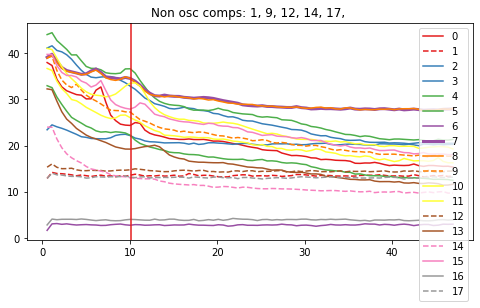

In [3]:
p_spectrum = loadmat(f'./data/spectra/dip_only/brian_diponly_{3}_spectra.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = specdata.mean(0)[0]
fg = fooof.FOOOFGroup(aperiodic_mode='fixed', verbose = False, min_peak_height = 0.025)
fg.fit(specfreqs, group_spec.T, [3, 40])
oscs = fg.get_params('peak_params', 'CF')
bumpy_comps = set([int(i) for i in oscs[:,1]])

n_ = group_spec.shape[1]
color = plt.cm.Set1(np.linspace(0, 1,n_)) #color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
flat_comps = 'Non osc comps: '
plt.figure(figsize=(8,4))
for i in range(n_):
    lw = 1.5
    linestyle = '-'
    if i not in bumpy_comps:
        linestyle = '--'
        flat_comps += "{}, ".format(i)
    if i == 7: lw = 3
    plt.plot(specfreqs[:84], group_spec[:,i][:84], linestyle = linestyle, marker='',markevery=[17],label = str(i), lw = lw)
plt.axvline(10.151271039)
plt.legend()
plt.title(flat_comps)
plt.show()

## Aperiodic fits


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



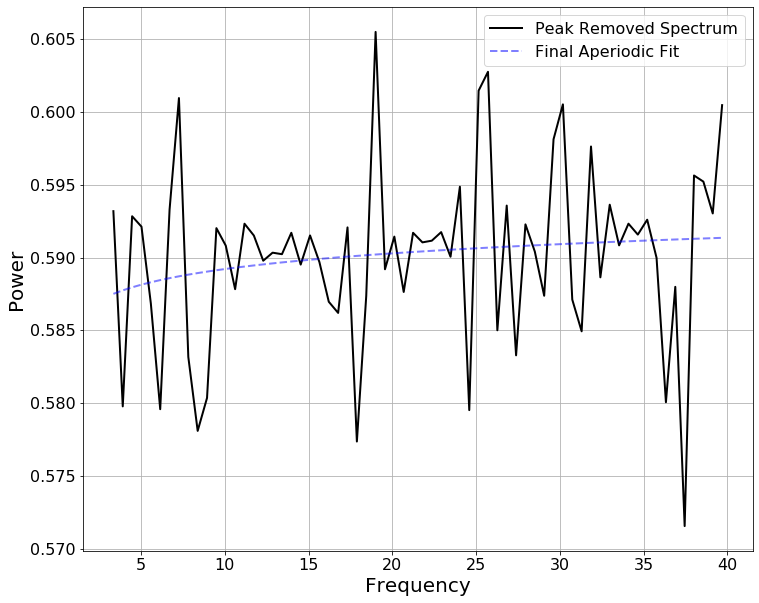

In [8]:
test_spec = group_spec[:,16]; plt_log = 0;
fm = fooof.FOOOF(aperiodic_mode='fixed')
fm.add_data(specfreqs,test_spec, [3, 40])
fm.fit(specfreqs, test_spec, [3, 40])
_, ax = plt.subplots(figsize=(12, 10))
plot_spectrum(fm.freqs, fm._spectrum_peak_rm, plt_log,
              label='Peak Removed Spectrum', color='black', ax=ax)
plot_spectrum(fm.freqs, fm._ap_fit, plt_log, label='Final Aperiodic Fit',
              color='blue', alpha=0.5, linestyle='dashed', ax=ax)

## r<sup>2</sup> distributions: removing noisy peaks

In [45]:
exponent = group_df[f'cluster {10}']['spectral exponent'][6]
f = lambda x: 1/(x**-exponent)
x_val = group_df[f'cluster {10}']['peak data']['CF'][3][0]
y_coord =  10**group_df[f'cluster {10}']['peak data']['PW'][3][0] #+ 10**f(x_val)

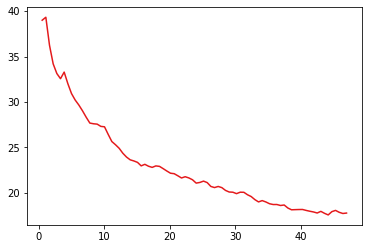

In [42]:
plt.plot(specfreqs[:84], group_spec[:,9][:84])

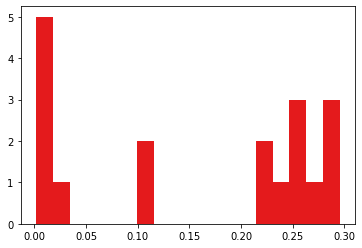

In [10]:
plt.hist(fg.get_params('aperiodic_params', 'exponent'), bins=18)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

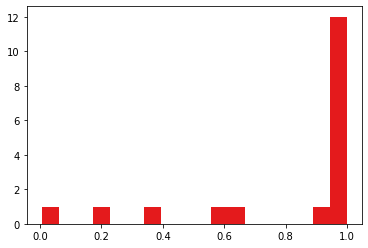

In [13]:
plt.hist(fg.get_params('r_squared'), bins=18); plt.show

# Cross condition peak locating

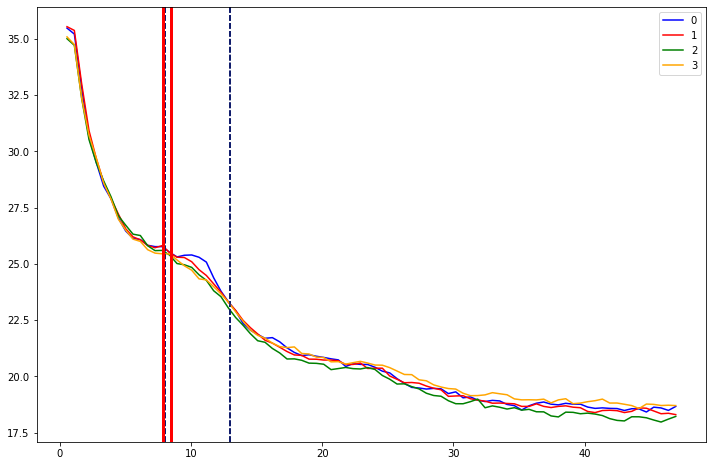

In [21]:
p_spectrum = loadmat('./data/spectra/dip_only/brian_diponly_{}_spectra.mat'.format(13))
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])
colors = ['b','r','g','orange'] # PL, PR, TL, TR
plt.figure(figsize=[12,8])
for i in range(4):
    plt.plot(specfreqs[:84], group_spec[i][:84], color = colors[i], label = str(i))
    #plt.xlim([5,14])
    # theta - alpha range
     plt.axvline(4, linestyle = '--'); plt.axvline(13, linestyle = '--')
        #cl14 peaks
#     plt.axvline(8.5, color = 'red', lw = 3);     plt.axvline(7.85, color = 'red', lw = 3)
    plt.axvline(8.5, color = 'red', lw = 3);     plt.axvline(7.85, color = 'red', lw = 3)

plt.legend()

In [ ]:
single_spec_fit = dict.fromkeys(['cluster {}'.format(i) for i in range(3,15)])
for k in single_spec_fit.keys():
    single_spec_fit[k] = {'PR':[], 'PL':[], 'TL':[], 'TR':[]}    

# Some tests 
Just to see how to use FOOOF and how to load exported spectral data
- Notice the variance in the non averaged spectrum.  

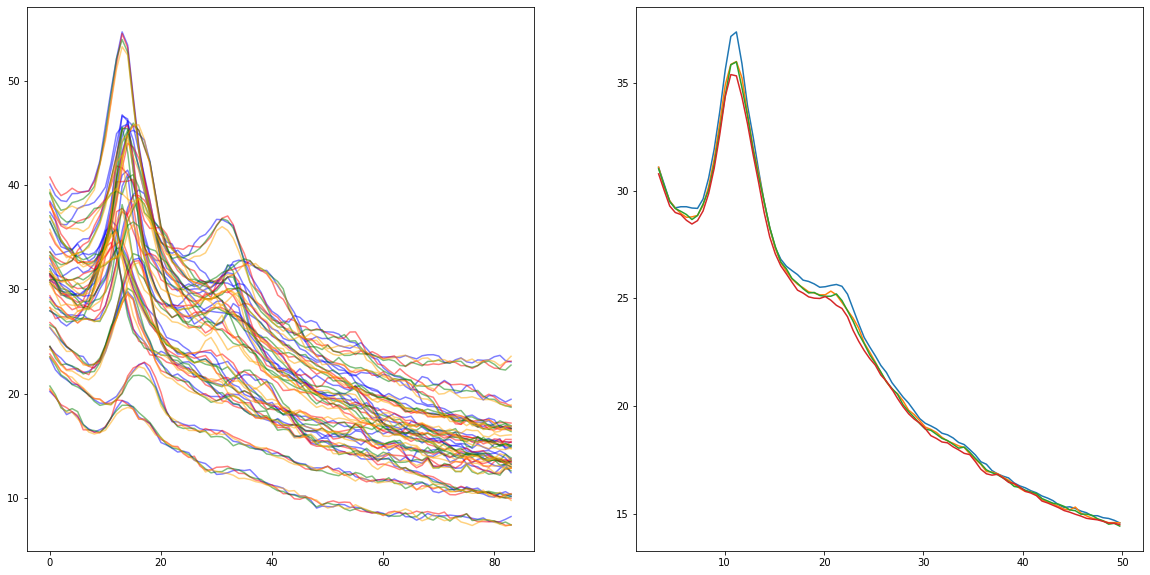

In [6]:
# data from dipole location + ERSP clustering; cluster 5
p_spectrum = loadmat('./data/spectra/dip5_specdata.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']

group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
colors = ['b','r','g','orange']
for i in range(4):
    plt.plot(specdata[i][0], color = colors[i], alpha = 0.5)

plt.subplot(1,2,2)
for i in range(4):
    plt.plot(specfreqs, group_spec[i])
    
#plt.legend()

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
            

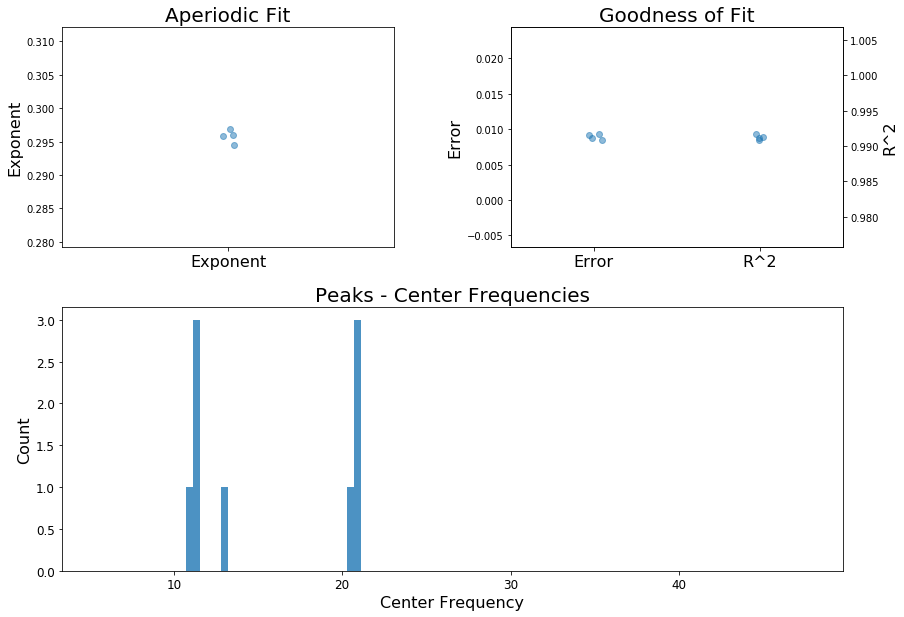

In [42]:
fg = fooof.FOOOFGroup()
fg.fit(specfreqs, group_spec)
freqrange = [3,50]
fg.report(specfreqs, group_spec, freqrange)

## Single FOOOF - One condition


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

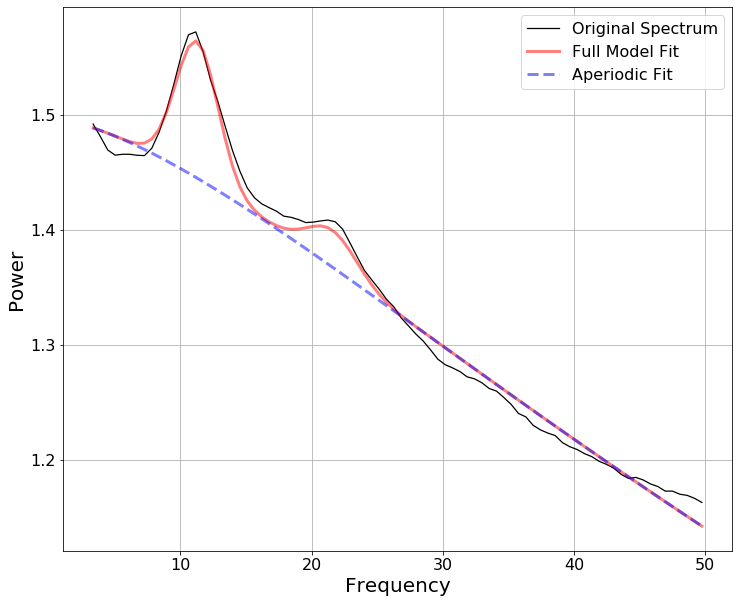

In [4]:
fg = fooof.FOOOF(aperiodic_mode='knee')
fg.fit(specfreqs, group_spec[0])
freqrange = [3,50]
fg.report(specfreqs, group_spec[0], freqrange)

# All dipole only clusters

This spectrum has 229 points for some reason

In [10]:
dip_only_spec = loadmat('./data/dip_only/brian_diponly_all_spectra.mat')


In [18]:
dip_only_spec['specdata'][0][0].shape


(229, 11)

In [20]:
dip_only_spec['specfreqs'].shape

(1, 229)

In [29]:
dip_only_spec3 = loadmat('./data/dip_only/brian_diponly_3_spectra.mat')
specfreqs3, specdata3 = dip_only_spec3['specfreqs'][0], dip_only_spec3['specdata']

group_spec3 = np.array([specdata3[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

In [30]:
dip_only_spec3['specdata'][0][0].shape

(229, 18)

In [34]:
group_spec3.shape

(4, 229)

In [33]:
group_spec.shape

(4, 84)